In [18]:
import re
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np 

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [20]:
# Hyper-parameters
sequence_length = 28
hidden_size = 128
num_layers = 3
num_classes = 1
batch_sizeRNN = 100
num_epochs = 2
learning_rate = 0.001

In [21]:
df=pd.read_csv(r"C:\Users\User\Soft Computing\Assignment 3\Assignemnt/Dataset 2.csv",header=None,encoding='unicode_escape')
df.to_csv(r"C:\Users\User\Soft Computing\Assignment 3\Assignemnt/modifiedataset2.csv",header=None, index=False)

In [22]:
ds=pd.read_csv(r"C:\Users\User\Soft Computing\Assignment 3\Assignemnt/modifiedataset2.csv",header=None,encoding='unicode_escape')
ds.columns = ["review", "label"]
ds.head(15)

,review,label
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
5,so sleepy. good times tonight though,0
6,"@SilkCharm re: #nbn as someone already said, d...",0
7,23 or 24ÃÂ¯ÃÂ¿ÃÂ½C possible today. Nice,0
8,nite twitterville workout in the am -ciao,0
9,"@daNanner Night, darlin'! Sweet dreams to you",0


In [23]:
#conveting to lower case
ds["review"] = ds["review"].str.lower()
ds.head(15)

,review,label
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat need to send 'em to my accountant tomo...,0
4,add me on myspace!!! myspace.com/lookthunder,0
5,so sleepy. good times tonight though,0
6,"@silkcharm re: #nbn as someone already said, d...",0
7,23 or 24ãâ¯ãâ¿ãâ½c possible today. nice,0
8,nite twitterville workout in the am -ciao,0
9,"@dananner night, darlin'! sweet dreams to you",0


In [24]:
def remove_users(tweet):
    """Takes a string and removes retweet and @user information"""
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove re-tweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove tweeted at
    return tweet
ds["review"] = ds["review"].apply(lambda text: remove_users(text))
ds.head(15)

,review,label
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,http://twitpic.com/2y2lx - http://www.youtube...,0
3,need to send 'em to my accountant tomorrow. o...,0
4,add me on myspace!!! myspace.com/lookthunder,0
5,so sleepy. good times tonight though,0
6,"re: #nbn as someone already said, does fiber ...",0
7,23 or 24ãâ¯ãâ¿ãâ½c possible today. nice,0
8,nite twitterville workout in the am -ciao,0
9,"night, darlin'! sweet dreams to you",0


In [25]:
def remove_links(tweet):
    """Takes a string and removes web links from it"""
    tweet = re.sub(r'http\S+', '', tweet)   # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # remove bitly links
    tweet = tweet.strip('[link]')   # remove [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    return tweet
ds["review"] = ds["review"].apply(lambda text: remove_links(text))
ds.head(15)

,review,label
0,just had a real good moment. i missssssssss hi...,0
1,s reading manga,0
2,-,0
3,need to send 'em to my accountant tomorrow. o...,0
4,add me on myspace!!! myspace.com/lookthunder,0
5,so sleepy. good times tonight though,0
6,"re: #nbn as someone already said, does fiber ...",0
7,23 or 24ãâ¯ãâ¿ãâ½c possible today. nice,0
8,te twitterville workout in the am -ciao,0
9,"night, darlin'! sweet dreams to you",0


In [26]:
def remove_hashtags(tweet):
    """Takes a string and removes any hash tags"""
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove hash tags
    return tweet
ds["review"] = ds["review"].apply(lambda text: remove_hashtags(text))
ds.head(15)

,review,label
0,just had a real good moment. i missssssssss hi...,0
1,s reading manga,0
2,-,0
3,need to send 'em to my accountant tomorrow. o...,0
4,add me on myspace!!! myspace.com/lookthunder,0
5,so sleepy. good times tonight though,0
6,"re: as someone already said, does fiber to t...",0
7,23 or 24ãâ¯ãâ¿ãâ½c possible today. nice,0
8,te twitterville workout in the am -ciao,0
9,"night, darlin'! sweet dreams to you",0


In [27]:
def remove_av(tweet):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    tweet = re.sub('VIDEO:', '', tweet)  # remove 'VIDEO:' from start of tweet
    tweet = re.sub('AUDIO:', '', tweet)  # remove 'AUDIO:' from start of tweet
    return tweet
ds["review"] = ds["review"].apply(lambda text: remove_av(text))
ds.head(15)

,review,label
0,just had a real good moment. i missssssssss hi...,0
1,s reading manga,0
2,-,0
3,need to send 'em to my accountant tomorrow. o...,0
4,add me on myspace!!! myspace.com/lookthunder,0
5,so sleepy. good times tonight though,0
6,"re: as someone already said, does fiber to t...",0
7,23 or 24ãâ¯ãâ¿ãâ½c possible today. nice,0
8,te twitterville workout in the am -ciao,0
9,"night, darlin'! sweet dreams to you",0


In [28]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

ds["review"] = ds["review"].apply(lambda text: remove_emoji(text))

In [29]:
EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}
def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)

ds["review"] = ds["review"].apply(lambda text: remove_emoticons(text))

In [30]:
#removing chat_words
chat_words_str = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
"""

chat_words_map_dict = {}
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

ds["review"] = ds["review"].apply(lambda text: chat_words_conversion(text))


In [31]:
import string
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

ds["review"] = ds["review"].apply(lambda text: remove_punctuation(text))
ds.head(15)

,review,label
0,just had a real good moment i missssssssss him...,0
1,s reading manga,0
2,,0
3,need to send em to my accountant tomorrow oddl...,0
4,add me on myspace myspacecomlookthunder,0
5,so sleepy good times tonight though,0
6,re as someone already said does fiber to the h...,0
7,23 or 24ãâ¯ãâ¿ãâ½c possible today nice,0
8,te twitterville workout in the am ciao,0
9,night darlin sweet dreams to you,0


In [32]:
def remove_doubplespace(tweet):
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    return tweet
ds["review"] = ds["review"].apply(lambda text: remove_doubplespace(text))
ds.head(15)

,review,label
0,just had a real good moment i missssssssss him...,0
1,s reading manga,0
2,,0
3,need to send em to my accountant tomorrow oddl...,0
4,add me on myspace myspacecomlookthunder,0
5,so sleepy good times tonight though,0
6,re as someone already said does fiber to the h...,0
7,23 or 24ãâ¯ãâ¿ãâ½c possible today nice,0
8,te twitterville workout in the am ciao,0
9,night darlin sweet dreams to you,0


In [33]:
def remove_numbers(tweet):
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    return tweet
ds["review"] = ds["review"].apply(lambda text: remove_doubplespace(text))
ds.head(15)

,review,label
0,just had a real good moment i missssssssss him...,0
1,s reading manga,0
2,,0
3,need to send em to my accountant tomorrow oddl...,0
4,add me on myspace myspacecomlookthunder,0
5,so sleepy good times tonight though,0
6,re as someone already said does fiber to the h...,0
7,23 or 24ãâ¯ãâ¿ãâ½c possible today nice,0
8,te twitterville workout in the am ciao,0
9,night darlin sweet dreams to you,0


In [34]:
import gensim
from nltk.stem import WordNetLemmatizer

def lemmatize(token):
    """Returns lemmatization of a token"""
    return WordNetLemmatizer().lemmatize(token, pos='v')

def tokenize(tweet):
    """Returns tokenized representation of words in lemma form excluding stopwords"""
    result = []
    for token in gensim.utils.simple_preprocess(tweet):
        if token not in gensim.parsing.preprocessing.STOPWORDS \
                and len(token) > 2:  # drops words with less than 3 characters
            result.append(lemmatize(token))
    tweet = ' '.join(result)
    return tweet
ds["review"] = ds["review"].apply(lambda text: tokenize(text))
ds.head(15)

,review,label
0,real good moment miss,0
1,read manga,0
2,,0
3,need send accountant tomorrow oddly wasnt refe...,0
4,add myspace,0
5,sleepy good time tonight,0
6,say fiber home mean regular,0
7,â½c possible today nice,0
8,twitterville workout ciao,0
9,night darlin sweet dream,0


In [35]:
#Removing any thing other than english
import nltk
words = set(nltk.corpus.words.words())
f = lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words)
ds["review"] = ds["review"].apply(f)
ds.head(15)

,review,label
0,real good moment miss,0
1,read manga,0
2,,0
3,need send accountant tomorrow oddly wasnt refe...,0
4,add,0
5,sleepy good time tonight,0
6,say fiber home mean regular,0
7,possible today nice,0
8,workout,0
9,night sweet dream,0


In [36]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
ds["review"] = ds["review"].apply(lambda text: correct_spellings(text))


In [37]:
ds.isnull().sum()

review    0
label     0
dtype: int64

In [38]:
ds.head(15)

,review,label
0,real good moment miss,0
1,read manga,0
2,,0
3,need send accountant tomorrow oddly wasnt refe...,0
4,add,0
5,sleepy good time tonight,0
6,say fiber home mean regular,0
7,possible today nice,0
8,workout,0
9,night sweet dream,0


In [39]:
df1=ds
df1.dropna(inplace = True)
df1.isnull().sum()

review    0
label     0
dtype: int64

In [42]:
df1.to_csv(r"C:\Users\User\Soft Computing\Assignment 3\Assignemnt/prepro.csv",header=None, index=False)
DATA_PATH=(r"C:\Users\User\Soft Computing\Assignment 3\Assignemnt/prepro.csv")

In [43]:
df = pd.read_csv(DATA_PATH, header=None,encoding='unicode_escape')
df.columns = ["review", "label"]
df.head(15)

,review,label
0,real good moment miss,0
1,read manga,0
2,NaN,0
3,need send accountant tomorrow oddly wasnt refe...,0
4,add,0
5,sleepy good time tonight,0
6,say fiber home mean regular,0
7,possible today nice,0
8,workout,0
9,night sweet dream,0


In [44]:
df.isnull().sum()

review    312
label       0
dtype: int64

In [45]:
df1=df
df1.dropna(inplace = True)
df1.isnull().sum()

review    0
label     0
dtype: int64

In [46]:
df1.to_csv(r"C:\Users\User\Soft Computing\Assignment 3\Assignemnt/prepro.csv",header=None, index=False)
DATA_PATH=(r"C:\Users\User\Soft Computing\Assignment 3\Assignemnt/prepro.csv")

In [47]:
df = pd.read_csv(DATA_PATH, header=None,encoding='unicode_escape')
df.columns = ["review", "label"]
df.head(15)

,review,label
0,real good moment miss,0
1,read manga,0
2,need send accountant tomorrow oddly wasnt refe...,0
3,add,0
4,sleepy good time tonight,0
5,say fiber home mean regular,0
6,possible today nice,0
7,workout,0
8,night sweet dream,0
9,good morning everybody,0


In [48]:
df.isnull().sum()

review    0
label     0
dtype: int64

In [49]:
df["label"]=df["label"]*(-1)
df.tail(15)

,review,label
9986,guess sacrifice want achieve dream family supp...,-1
9987,engage physical activity decrease people chanc...,-1
9988,depression darling,-1
9989,suffer depression thankful guy help love guy d...,-1
9990,teens anxiety depression,-1
9991,go week excite depression go asthma heal happy...,-1
9992,bush trump slogan rob treasury rob soc sec sav...,-1
9993,depression improve vitamin deficiency treatmen...,-1
9994,adult depression naked blow family sexy girl,-1
9995,book court law provoke suicide say work slip,-1


In [50]:
df["label"]=df["label"]+1
df.head(15)

,review,label
0,real good moment miss,1
1,read manga,1
2,need send accountant tomorrow oddly wasnt refe...,1
3,add,1
4,sleepy good time tonight,1
5,say fiber home mean regular,1
6,possible today nice,1
7,workout,1
8,night sweet dream,1
9,good morning everybody,1


In [51]:
df.to_csv(r"C:\Users\User\Soft Computing\Assignment 3\Assignemnt/labelchange.csv",header=None, index=False)

In [53]:
DATA_PATH=(r"C:\Users\User\Soft Computing\Assignment 3\Assignemnt/labelchange.csv")

In [54]:
class Sequences(Dataset):
    def __init__(self, data):
        self.vectorizer = CountVectorizer(stop_words='english')
        self.sequences = self.vectorizer.fit_transform(data.review.tolist())
        self.labels = data.label.tolist()
        self.token2idx = self.vectorizer.vocabulary_
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
    
    def __getitem__(self, i):
        return self.sequences[i, :].toarray(), self.labels[i]
    
    def __len__(self):
        return self.sequences.shape[0]

In [55]:
df = pd.read_csv(DATA_PATH, header=None,encoding='unicode_escape')

df.columns = ["review", "label"]
df = df.sample(frac=1)
train_size=int(len(df)*0.8)
df_train = df.head(train_size)
print(len(df_train))
df_test = df.tail(int(len(df)*0.2))
print(len(df_test))
dataset = Sequences(df_train)
print(len(dataset))
train_loader = DataLoader(dataset, batch_size=500)
print(len(train_loader))

8000
2000
8000
16


In [56]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True,bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [57]:
model = RNN(len(dataset.token2idx), hidden_size, num_layers,num_classes)
model.to(device)
model

RNN(
  (rnn): RNN(5170, 128, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [58]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [59]:
train_losses = []
total_step = train_size
for epoch in range(200):
    losses = []
    total = 0
    for inputs, target in train_loader:
        
        inputs=inputs.float()
        inputs=inputs.to(device)
       
        targets=target.float()
        target=targets.to(device)
        
        model.zero_grad()
        
        output = model(inputs)
        loss = criterion(output.squeeze(), target)
        
        loss.backward()
          
        optimizer.step()
        
        losses.append(loss.item())
        total += 1
        
    epoch_loss = sum(losses) / total
    train_losses.append(epoch_loss)
        
    print(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.10f}')
    

Epoch #1	Train Loss: 0.4136005407
Epoch #2	Train Loss: 0.0893862485
Epoch #3	Train Loss: 0.0415787356
Epoch #4	Train Loss: 0.0231776376
Epoch #5	Train Loss: 0.0150255462
Epoch #6	Train Loss: 0.0134363658
Epoch #7	Train Loss: 0.0135965849
Epoch #8	Train Loss: 0.0131719446
Epoch #9	Train Loss: 0.0100316281
Epoch #10	Train Loss: 0.0120575641
Epoch #11	Train Loss: 0.0132539057
Epoch #12	Train Loss: 0.0141057714
Epoch #13	Train Loss: 0.0089898121
Epoch #14	Train Loss: 0.0092588252
Epoch #15	Train Loss: 0.0099317291
Epoch #16	Train Loss: 0.0069109897
Epoch #17	Train Loss: 0.0059677086
Epoch #18	Train Loss: 0.0070799342
Epoch #19	Train Loss: 0.0061125247
Epoch #20	Train Loss: 0.0054656065
Epoch #21	Train Loss: 0.0064002409
Epoch #22	Train Loss: 0.0058719743
Epoch #23	Train Loss: 0.0052564972
Epoch #24	Train Loss: 0.0059012333
Epoch #25	Train Loss: 0.0062672669
Epoch #26	Train Loss: 0.0051135398
Epoch #27	Train Loss: 0.0052760771
Epoch #28	Train Loss: 0.0069455865
Epoch #29	Train Loss: 0.00630

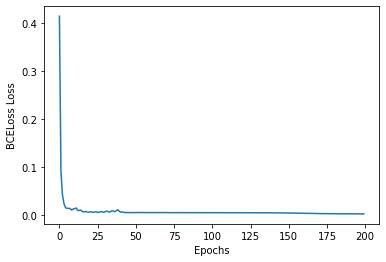

In [60]:
import matplotlib
import matplotlib.pyplot as plt

#print (train_losses)
plt.plot(train_losses)
plt.ylabel('BCELoss Loss')
plt.xlabel('Epochs')
plt.savefig(r"C:\Users\User\Soft Computing\Assignment 3\Assignemnt\loss.png")
plt.show()

In [61]:
root_path = r'C:\Users\User\Soft Computing\Assignment 3\Assignemnt\Assignment 3'
save_model = True

if save_model is True:
    # Saves only parameters
    # weights & biases
    torch.save(model.state_dict(), root_path + 'Assignment3') 

load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'Assignment3'))
    print('Trained Model Loaded')

Trained Model Loaded


In [62]:
def predict_sentiment(text):
  test_vector= torch.LongTensor(dataset.vectorizer.transform([text]).toarray()).to(device)

  test_vector=test_vector.unsqueeze(1)
  output = model(torch.tensor(test_vector , dtype=torch.float))
  prediction = torch.sigmoid(output).item()
  
  if prediction > 0.5:
    print(f'{prediction:0.3}: Positive sentiment')
    return 1
  else:
    print(f'{prediction:0.3}: Negative sentiment')
    return 0

In [63]:
test_text = "Sometimes I think life has no meaning.I am worthless.It will not matter if I die."
predict_sentiment(test_text)

4.97e-07: Negative sentiment


C:\Users\User\AppData\Local\Temp/ipykernel_6492/1129984432.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(test_vector , dtype=torch.float))


0

In [64]:
test_text = "Excellent cast, story line, performances."
predict_sentiment(test_text)

0.997: Positive sentiment


C:\Users\User\AppData\Local\Temp/ipykernel_6492/1129984432.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(test_vector , dtype=torch.float))


1

In [65]:
test_text = "Its a good life."
predict_sentiment(test_text)

1.0: Positive sentiment


C:\Users\User\AppData\Local\Temp/ipykernel_6492/1129984432.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(test_vector , dtype=torch.float))


1

In [66]:
test_text = "I am happy."
predict_sentiment(test_text)

1.0: Positive sentiment


C:\Users\User\AppData\Local\Temp/ipykernel_6492/1129984432.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(test_vector , dtype=torch.float))


1

In [67]:
test_text = "I am sad."
predict_sentiment(test_text)

2.68e-05: Negative sentiment


C:\Users\User\AppData\Local\Temp/ipykernel_6492/1129984432.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(test_vector , dtype=torch.float))


0

In [68]:
test_text = "somebody killed him."
predict_sentiment(test_text)

0.00159: Negative sentiment


C:\Users\User\AppData\Local\Temp/ipykernel_6492/1129984432.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(test_vector , dtype=torch.float))


0

In [69]:
test_text = "Just kill me."
predict_sentiment(test_text)

1.0: Positive sentiment


C:\Users\User\AppData\Local\Temp/ipykernel_6492/1129984432.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(test_vector , dtype=torch.float))


1

In [70]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
pred_labels = []

sentences = list(df_test['review'])
labels = df_test['label']

print(sentences)

for sentence in sentences:
  pred_labels.append(predict_sentiment(sentence))

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(labels, pred_labels)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(labels, pred_labels)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(labels, pred_labels)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(labels, pred_labels)
print('F1 score: %f' % f1)

# confusion matrix
matrix = confusion_matrix(labels, pred_labels)
print(matrix)

['new hand bag fabulous', 'bed sugar', 'support scientifically debunk fact youve clearly experience severe mental illness situational depression long term depression thing suggest research genetic factor cause depression bipolar', 'sleep late bite depression creep hope wont episode', 'get ready great day tune talk get great picture wed day', 'people welcome depression live like cool thing depress depress want include aura depression neutral face', 'love bowl today figure run', 'villainous state', 'have good night go dinner coffee tonight good', 'able pull depression thats great dont like work work boo mental cope big spectrum believe like', 'depression anxiety panic disorder stress functional disorder addiction psychoses', 'thankful people life help depression dont know kind love support', 'way pick', 'waste', 'thats possibility actually soldier local cop pastime', 'guy little balance run', 'perfectionist work time', 'blush feel bite fluffy', 'depression prison suffer prisoner cruel ja

C:\Users\User\AppData\Local\Temp/ipykernel_6492/1129984432.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(test_vector , dtype=torch.float))


1.0: Positive sentiment
1.0: Positive sentiment
6.48e-07: Negative sentiment
6.44e-07: Negative sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
7.21e-07: Negative sentiment
1.0: Positive sentiment
1.0: Positive sentiment
0.0806: Negative sentiment
1.0: Positive sentiment
0.00785: Negative sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
3.7e-07: Negative sentiment
1.0: Positive sentiment
1.0: Positive sentiment
6.14e-07: Negative sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
0.606: Positive sentiment
0.000439: Negative sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
6.

0.917: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
6.92e-07: Negative sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.09e-06: Negative sentiment
1.0: Positive sentiment
7.06e-07: Negative sentiment
0.818: Positive sentiment
7.01e-07: Negative sentiment
1.0: Positive sentiment
5.87e-07: Negative sentiment
2.52e-06: Negative sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
6.51e-07: Negative sentiment
6.89e-07: Negative sentiment
1.0: Positive sentiment
0.957: Positive sentiment
4.91e-07: Negative sentiment
5.25e-07: Negative sentiment
1.0: Pos

0.922: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.08e-06: Negative sentiment
5.04e-07: Negative sentiment
5.18e-07: Negative sentiment
1.0: Positive sentiment
6.81e-07: Negative sentiment
1.17e-06: Negative sentiment
1.0: Positive sentiment
1.0: Positive sentiment
2.95e-07: Negative sentiment
1.0: Positive sentiment
0.0502: Negative sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
0.996: Positive sentiment
1.0: Positive sentiment
7.14e-07: Negative sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
0.118: Negative sentiment
0.0331: Negative sentiment
1.0: Positive sentiment
1.18e-06: Negative sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
6.13e-07: Negative sentiment
6.91e-0

0.00956: Negative sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
7.03e-07: Negative sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
6.04e-07: Negative sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
5.48e-07: Negative sentiment
1.1e-05: Negative sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
6.39e-07: Negative sentiment
6.4e-07: Negative sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
6.39e-07

1.0: Positive sentiment
6.13e-06: Negative sentiment
6.83e-06: Negative sentiment
5.31e-07: Negative sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
6.52e-07: Negative sentiment
1.0: Positive sentiment
1.0: Positive sentiment
0.818: Positive sentiment
1.0: Positive sentiment
0.653: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
8.82e-07: Negative sentiment
1.0: Positive sentiment
5.21e-07: Negative sentiment
1.0: Positive sentiment
6.66e-07: Negative sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
0.000102: Negative sentiment
3.79e-07: Negative sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
0.989: Positive sentiment
7.13e-07: Negative sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Positive sentiment
1.0: Pos

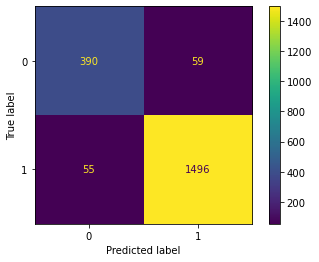

In [75]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
lab=[0,1]
disp = ConfusionMatrixDisplay(confusion_matrix=matrix,
                               display_labels=lab)
disp.plot()
plt.savefig(r"C:\Users\User\Soft Computing\Assignment 3\Assignemnt\confusionmatrix.png")
plt.show()